### Introduction
Le SFT pour notre application necessite plusieurs actions sur les données et sur le modèle.

### Objectifs:  
1. Enrichir les données
2. Benchmark des modèles : comparer les modèles sur les données enrichies
3. Fine tuning du modèle choisi 

# 1. Enrichir les données

#### Aggregation 

In [1]:
#Enrichir les données : fonction utilitaire
import pandas as pd
import numpy as np
import gc

def aggregate_numeric(df, group_var, df_name):
    """Agrège les colonnes numériques en calculant min, max, mean, sum.
    @Args : 
        df :
        group_var:
        df_name:
    @Returns :
        agg: tables aggrégées 
    """
    
    # Suppression de l'ID pour ne pas l'agréger
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns=col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Création de noms de colonnes explicites
    columns = [group_var]
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append(f'{df_name}_{var}_{stat}')
    
    agg.columns = columns
    return agg

def aggregate_categorical(df, group_var, df_name):
    """Agrège les colonnes catégorielles en calculant la fréquence (mean)."""
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    
    agg = categorical.groupby(group_var).mean().reset_index()
    
    # Renommer
    columns = [group_var]
    for col in agg.columns:
        if col != group_var:
            columns.append(f'{df_name}_{col}_mean')
    agg.columns = columns
    return agg

In [2]:
# fusion de toutes les tables 
def get_dataset():
    """ cette fonction centralise la lecture et la fusion de toutes les tables.
    @Args :
        void()
    @Returns:
        df : table de données aggrégées

    """
    # --- 1. CHARGEMENT TRAIN + TEST ---
    train = pd.read_csv('data/application_train.csv')
    test = pd.read_csv('data/application_test.csv')
    
    # On marque les données pour les séparer plus tard
    train['is_train'] = 1
    test['is_train'] = 0
    
    # Union des deux (la colonne TARGET de test sera remplie de NaN automatiquement)
    df = pd.concat([train, test], axis=0, ignore_index=True)
    print(f"Initial shape (Train+Test): {df.shape}")

    # --- 2. BUREAU & BUREAU_BALANCE ---
    # (Le reste de ton code reste identique, car les SK_ID_CURR de test 
    #  seront trouvés dans les tables bureau, prev, etc.)
    bureau = pd.read_csv('data/bureau.csv')
    bureau_balance = pd.read_csv('data/bureau_balance.csv')
    bb_agg = aggregate_numeric(bureau_balance, 'SK_ID_BUREAU', 'bb')
    bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')
    bureau_agg_num = aggregate_numeric(bureau.drop(columns=['SK_ID_BUREAU']), 'SK_ID_CURR', 'bureau')
    bureau_agg_cat = aggregate_categorical(bureau.drop(columns=['SK_ID_BUREAU']), 'SK_ID_CURR', 'bureau')
    
    df = df.merge(bureau_agg_num, on='SK_ID_CURR', how='left')
    df = df.merge(bureau_agg_cat, on='SK_ID_CURR', how='left')
    del bureau, bureau_balance; gc.collect()

    # --- 3. PREVIOUS APPLICATIONS ---
    prev = pd.read_csv('data/previous_application.csv')
    prev_agg_num = aggregate_numeric(prev, 'SK_ID_CURR', 'prev')
    prev_agg_cat = aggregate_categorical(prev, 'SK_ID_CURR', 'prev')
    
    df = df.merge(prev_agg_num, on='SK_ID_CURR', how='left')
    df = df.merge(prev_agg_cat, on='SK_ID_CURR', how='left')
    del prev; gc.collect()

    # --- 4. TABLES DE FLUX (POS, INSTALLMENTS, CREDIT CARD) ---
    for table_name, file in [('pos', 'data/POS_CASH_balance.csv'), 
                             ('ins', 'data/installments_payments.csv'), 
                             ('cc', 'data/credit_card_balance.csv')]:
        temp = pd.read_csv(file)
        temp_agg = aggregate_numeric(temp, 'SK_ID_CURR', table_name)
        df = df.merge(temp_agg, on='SK_ID_CURR', how='left')
        del temp; gc.collect()

    # Nettoyage final des noms (caractères spéciaux interdits par LightGBM/XGBoost)
    df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
    
    print(f"Final Dataset Shape: {df.shape}")
    return df

df_master = get_dataset()

Initial shape (Train+Test): (356255, 123)
Final Dataset Shape: (356255, 624)


### Feature selection 

In [3]:
# feature selection et quantitifation : changement de la representation des valeurs (float64 -> float 32) 

#### Selection par importance

In [4]:
import lightgbm as lgb
import matplotlib.pyplot as plt

def perform_feature_selection(df, target_col='TARGET', cumulative_threshold=0.90):
    print(f"Feature Selection initiale : {df.shape[1]} colonnes.")
    
    # Préparation des données
    X = df.drop(columns=[target_col, 'SK_ID_CURR'])
    y = df[target_col]
    
    # Entraînement d'un modèle rapide pour l'importance
    clf = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.1, importance_type='gain', verbosity=-1)
    clf.fit(X, y)
    
    # Calcul de l'importance relative
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Importance cumulée
    feature_importances['cumulative_importance'] = feature_importances['importance'].cumsum() / feature_importances['importance'].sum()
    
    # Sélection des features
    selected_features = feature_importances[feature_importances['cumulative_importance'] <= cumulative_threshold]['feature'].tolist()
    
    # Affichage du résultat
    print(f"Nombre de colonnes sélectionnées pour atteindre {cumulative_threshold*100}% d'importance : {len(selected_features)}")
    
    return selected_features, feature_importances


#### Nettoyage des noms des colonnes REGEX

In [5]:
# Utilisation
import re

# 1. Appliquer l'encodage
df_master_encoded = pd.get_dummies(df_master)
# 2. Nettoyer les noms de colonnes avec une Regex
# On remplace tout ce qui n'est pas un chiffre ou une lettre par un underscore "_"
new_cols = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df_master_encoded.columns]
df_master_encoded.columns = new_cols

# 3. Supprimer les éventuels doublons de noms créés par le nettoyage
df_master_encoded = df_master_encoded.loc[:, ~df_master_encoded.columns.duplicated()]
#========
# 1. On sépare les données dont on connaît la réponse (Train) 
# des données à prédire pour le Dashboard (Test)

df_test = df_master_encoded[df_master_encoded['TARGET'].isnull()]
df_train = df_master_encoded[df_master_encoded['TARGET'].notnull()]
y = df_train['TARGET']
# 2. On définit X et y uniquement sur la partie Train
#X_selection = df_train_ok.drop(columns=['TARGET', 'SK_ID_CURR'])
#y_selection = df_train_ok['TARGET']

# 3. On lance la sélection de variables sur ce sous-ensemble valide
#selected_cols, importance_df = perform_feature_selection(X_selection, y_selection)

# 4. (Optionnel) Une fois les colonnes choisies, on filtre df_master_encoded 
# pour ne garder que le nécessaire
#df_final_for_tuning = df_master_encoded[selected_cols + ['TARGET', 'SK_ID_CURR']]


#=========


print("Noms de colonnes nettoyés pour LightGBM.")

# 4. Maintenant, tu peux relancer la sélection sans erreur !
selected_cols, importance_df = perform_feature_selection(df_train)


Noms de colonnes nettoyés pour LightGBM.
Feature Selection initiale : 748 colonnes.
Nombre de colonnes sélectionnées pour atteindre 90.0% d'importance : 251


#### Reduction du nombre de colonnes : selection des colonnes (F.Imp)

In [6]:
# table reduite df_master_reduit
df_master = df_train[selected_cols]
print(f"shape1 :{df_master.shape}")
# Quantitifcation : float64 => float32
df_master_reduit = pd.concat([df_master.select_dtypes("number").astype("float32"),
                            df_master.select_dtypes(exclude = "number")],axis=1)
print(f"shape2 {df_master_reduit.shape}")

shape1 :(307511, 251)
shape2 (307511, 251)


In [7]:
df_test = df_test[selected_cols].copy()

In [8]:
del df_master , df_master_encoded,df_train
gc.collect()

80

#### Reduction des colonnes : Filtrage NaN

In [9]:
# suppression de variables ayant 75%+ de NaN
# Seuil de remplissage (ex: 0.25 signifie qu'on garde si au moins 25% des données sont présentes)
threshold = 0.25

# Calcul du taux de remplissage
fill_rates = df_master_reduit.count() / len(df_master_reduit)

# Identification des colonnes à garder
cols_to_keep = fill_rates[fill_rates >= threshold].index.tolist()


# Si tu veux absolument garder la TARGET et l'ID même si elles étaient vides (peu probable)
for essential in ['TARGET', 'SK_ID_CURR']:
    if essential not in cols_to_keep and essential in df_master_reduit.columns:
        cols_to_keep.append(essential)

df_master_filtered = df_master_reduit[cols_to_keep]

print(f"Colonnes supprimées car trop vides : {df_master_reduit.shape[1] - len(cols_to_keep)}")
print(f"Colonnes restantes : {len(cols_to_keep)}")

Colonnes supprimées car trop vides : 6
Colonnes restantes : 245


#### 2. Comparaison des modèles (Benchmark)

In [10]:
# On insere les contraintes métier
import numpy as np
from sklearn.metrics import confusion_matrix 

def optimize_threshold(y_true, y_probs):
    """
    Trouve le seuil qui minimise le coût métier : (10 * FN) + (1 * FP).
    
   @Args:
         y_true : les vraies étiquettes (0 ou 1)
        y_probs : les probabilités prédites par le modèle (pour la classe 1)
    @returns :
        best_treshold , min_cost
    """
    thresholds = np.linspace(0, 1, 101)  # Teste 100 seuils de 0.0 à 1.0
    costs = []
    
    for thr in thresholds:
        # On transforme la probabilité en prédiction binaire selon le seuil
        y_pred = (y_probs >= thr).astype(int)
        
        # Calcul de la matrice de confusion
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calcul du coût métier (pondération 10 pour les faux négatifs)
        current_cost = (10 * fn) + (1 * fp)
        costs.append(current_cost)
    
    # Trouver l'index du coût minimum
    best_index = np.argmin(costs)
    best_threshold = thresholds[best_index]
    min_cost = costs[best_index]
    
    return best_threshold, min_cost



In [11]:
# split data
from sklearn.model_selection import train_test_split

# On sépare la cible (y) du reste (X)
X = df_master_filtered

# Split 80% train / 20% test
# stratify=y est l'argument le plus important ici
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Entraînement : {X_train.shape[0]} lignes")
print(f"Test (Hold-out) : {X_test.shape[0]} lignes")
print(f"Taux de défaut en Train : {y_train.mean():.2%}")
print(f"Taux de défaut en Test : {y_test.mean():.2%}")

Entraînement : 246008 lignes
Test (Hold-out) : 61503 lignes
Taux de défaut en Train : 8.07%
Taux de défaut en Test : 8.07%


=== REPRISE === 

In [12]:
# Dictionnaire des modèles
### importations 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import mlflow
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score

# Préprocesseur pour les modèles linéaires/RF/MLP
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

benchmark_models = {
    "LogisticRegression": Pipeline(steps=[
        ('pre', numeric_transformer), 
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]),
    
    "RandomForest": Pipeline(steps=[
        ('pre', numeric_transformer), 
        ('clf', RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', n_jobs=-1))
    ]),
    
    "MLP_Classifier": Pipeline(steps=[
        ('pre', numeric_transformer), 
        ('clf', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42))
    ]),
    
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=500, 
        is_unbalance=True, 
        n_jobs=-1, 
        verbosity=-1,        
        importance_type='gain'
    ),
    
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500, 
        scale_pos_weight=11, 
        n_jobs=-1,
        verbosity=0,         
        random_state=42
    )
}
# Note : SVC est très lent sur de gros datasets. Teste-le sur un échantillon d'abord.
# "SVC": SVC(probability=True, class_weight='balanced')

In [13]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score

# Configuration de l'expérience
mlflow.set_experiment("Champion_Selection_Data")

# Remplacez par le chemin absolu pour être certain
mlflow.set_tracking_uri("sqlite:////Users/mpaga/Desktop/OC/Projet6/mlflow.db")

def run_final_benchmark(X, y):
    """ 
    @Docs: réalise le benchmmaking des modèles 

    @Args:
        X : df
        y : verteur de réponse
    @Returns: 
        affiche les resultas des différents entraînement des différents modèles.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in benchmark_models.items():
        with mlflow.start_run(run_name=f"Final_{name}"):
            print(f"Évaluation finale de : {name}...")
            
            # 1. Cross-validation pour obtenir les probabilités
            # n_jobs=-1 utilise tous tes cœurs pour aller plus vite
            y_probs = cross_val_predict(model, X, y, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]
            
            # 2. Calcul de l'AUC
            auc_cv = roc_auc_score(y, y_probs)
            
            # 3. Optimisation du seuil pour le Coût Métier
            # On cherche le seuil qui minimise : (10 * FN) + (1 * FP)
            best_thr, min_cost = optimize_threshold(y, y_probs)
            
            # 4. Logs Manuels MLflow
            mlflow.log_param("algo", name)
            mlflow.log_param("n_features", X.shape[1])
            mlflow.log_metric("auc_cv", auc_cv)
            mlflow.log_metric("business_score_cost", min_cost)
            mlflow.log_metric("optimal_threshold", best_thr)
            
            # Optionnel : Sauvegarder le modèle pour ce run
            # mlflow.sklearn.log_model(model, f"model_{name}")
            
            print(f"{name} : OK | AUC: {auc_cv:.4f} | Coût: {min_cost:.0f} | Seuil: {best_thr:.2f}")

# Lancement sur les colonnes sélectionnées
run_final_benchmark(X_train, y_train)

2026/02/05 18:23:01 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/05 18:23:01 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/05 18:23:01 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/05 18:23:01 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/05 18:23:01 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/05 18:23:01 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/05 18:23:01 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/05 18:23:01 INFO mlflow.store.db.utils: Updating database tables
2026/02/05 18:23:01 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/05 18:23:01 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/05 18:23:01 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/05 18:23:01 INFO alembic.runtime

Évaluation finale de : LogisticRegression...
LogisticRegression : OK | AUC: 0.7657 | Coût: 127428 | Seuil: 0.52
Évaluation finale de : RandomForest...
RandomForest : OK | AUC: 0.7464 | Coût: 133561 | Seuil: 0.46
Évaluation finale de : MLP_Classifier...
MLP_Classifier : OK | AUC: 0.6696 | Coût: 156903 | Seuil: 0.05
Évaluation finale de : LightGBM...
LightGBM : OK | AUC: 0.7694 | Coût: 125795 | Seuil: 0.42
Évaluation finale de : XGBoost...
XGBoost : OK | AUC: 0.7269 | Coût: 138853 | Seuil: 0.22


In [14]:
import pandas as pd

def get_best_model_from_benchmark(experiment_name="Champion_Selection_Data"):
    """ 
    @Docs:
    Recherche le meilleur modèle suivant le  coût optimal (le plus bas)/ le coût le plus bas en cas d'erreur de FN

    @Args:
        le nom de l'exp mlflow
    @Returns:
        le modèle promu 

    """
    # 1. Récupérer l'ID de l'expérience
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    # 2. Chercher tous les runs de cette expérience
    # On récupère les métriques et les paramètres sous forme de DataFrame
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    # 3. Trouver le run avec le coût métier le plus bas (min_cost)
    best_run = runs.loc[runs['metrics.business_score_cost'].idxmin()]
    
    print("-" * 30)
    print(f"Le meilleur modèle au regard du Coût : {best_run['params.algo']}")
    print("-" * 30)
    print(f"AUC (CV): {best_run['metrics.auc_cv']:.4f}")
    print(f"Coût Métier: {best_run['metrics.business_score_cost']:.0f}")
    print(f"Seuil Optimal: {best_run['metrics.optimal_threshold']:.3f}")
    print("-" * 30)
    
    return best_run['params.algo']


In [15]:

#Utilisation
winner = get_best_model_from_benchmark()

------------------------------
Le meilleur modèle au regard du Coût : LightGBM
------------------------------
AUC (CV): 0.7694
Coût Métier: 125795
Seuil Optimal: 0.420
------------------------------


### 3. Fine tuning 

#### RandomSerach CV

In [17]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

def fine_tune_champion(X_train, y_train, model_name="LightGBM"):
    """ 
    @Docs: 
    réalise le SFT du modèle choisi anvec Random search

    @Args:
        X_train:dataset d'entraînement
        y_train: réponse/feature cible
        model_name: nom du modèle
    @Returns:
        meilleur estimateur
    """
    print(f"Début du SFT pour {model_name}...")
    
    # Configuration de la grille pour le champion (Exemple LGBM)
    param_grid = {
        'n_estimators': [500, 1000, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 40, 64],
        'max_depth': [5, 10, 15, ],
        'min_child_samples': [20, 50, 100],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }

    # Le modèle de base (silencieux et gérant l'unbalance)
    base_model = lgb.LGBMClassifier(is_unbalance=True, verbosity=-1, n_jobs=-1)

    # Recherche aléatoire (n_iter=20 est un bon compromis temps/performance)
    search = RandomizedSearchCV(
        base_model, 
        param_distributions=param_grid, 
        n_iter=5, 
        scoring='roc_auc', 
        cv=3, 
        verbose=1, 
        n_jobs=-1,
        random_state=42
    )

    with mlflow.start_run(run_name=f"SFT_Final_{model_name}"):
        search.fit(X_train, y_train)
        
        # Log des meilleurs paramètres
        mlflow.log_params(search.best_params_)
        mlflow.sklearn.log_model(sk_model = search.estimator,name="best_lightGBM" , registered_model_name="best_lightGBM")
        
        print(f"Meilleur AUC trouvé : {search.best_score_:.4f}")
        return search.best_estimator_

best_model = fine_tune_champion(X_train, y_train)

Début du SFT pour LightGBM...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


2026/02/05 19:13:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/02/05 19:13:29 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/05 19:13:29 INFO mlflow.store.db.utils: Updating database tables
2026/02/05 19:13:29 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/05 19:13:29 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Meilleur AUC trouvé : 0.7801


Successfully registered model 'best_lightGBM'.
Created version '1' of model 'best_lightGBM'.


### INFERENCE 

In [18]:
 # 1. Récupérer l'ID de l'expérience
#experiment = mlflow.get_experiment_by_name("Champion_Selection_Data")
    
    # 2. Chercher tous les runs de cette expérience
    # On récupère les métriques et les paramètres sous forme de DataFrame
#runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    # 3. Trouver le run avec le coût métier le plus bas (min_cost)
#best_run = runs.loc[runs['metrics.business_score_cost'].idxmin()]


In [20]:

model_name = "best_lightGBM"
model_version = "latest"

# Load the model from the Model Registry
model_uri = f"models:/{model_name}/{model_version}"
best_model = mlflow.sklearn.load_model(model_uri)

In [21]:
# Score final 
# 1. On prend le meilleur modèle 
best_model.fit(X_train, y_train) # Entraînement final

# 2. Prédiction sur le Test Set (le vrai !)
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# 3. Calcul du coût réel avec le seuil trouvé lors du benchmark
final_auc = roc_auc_score(y_test, y_test_probs)
best_threshold, final_cost = optimize_threshold(y_test, y_test_probs)

print(f"final AUC : {final_auc:.4f}")
print(f"best treshold :{best_threshold:.4f}")
print(f"final_cost :{final_cost:.4f}")

# 4. Log final dans MLflow
with mlflow.start_run(run_name="FINAL_MODEL_EVALUATION"):
    mlflow.log_metric("final_auc_test", final_auc)
    mlflow.log_metric("final_business_cost_test", final_cost)
    mlflow.log_metric("best_threshold", best_threshold)
    mlflow.sklearn.log_model(best_model, name="final_scoring_model",registered_model_name="best_lightGBM")

final AUC : 0.7823
best treshold :0.5200
final_cost :30249.0000


2026/02/05 19:14:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


#### ANALYSE GLOBALE 

/Users/mpaga/Desktop/OC/Projet6/projet6/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mpaga/Desktop/OC/Projet6/projet6/lib/python3.13/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


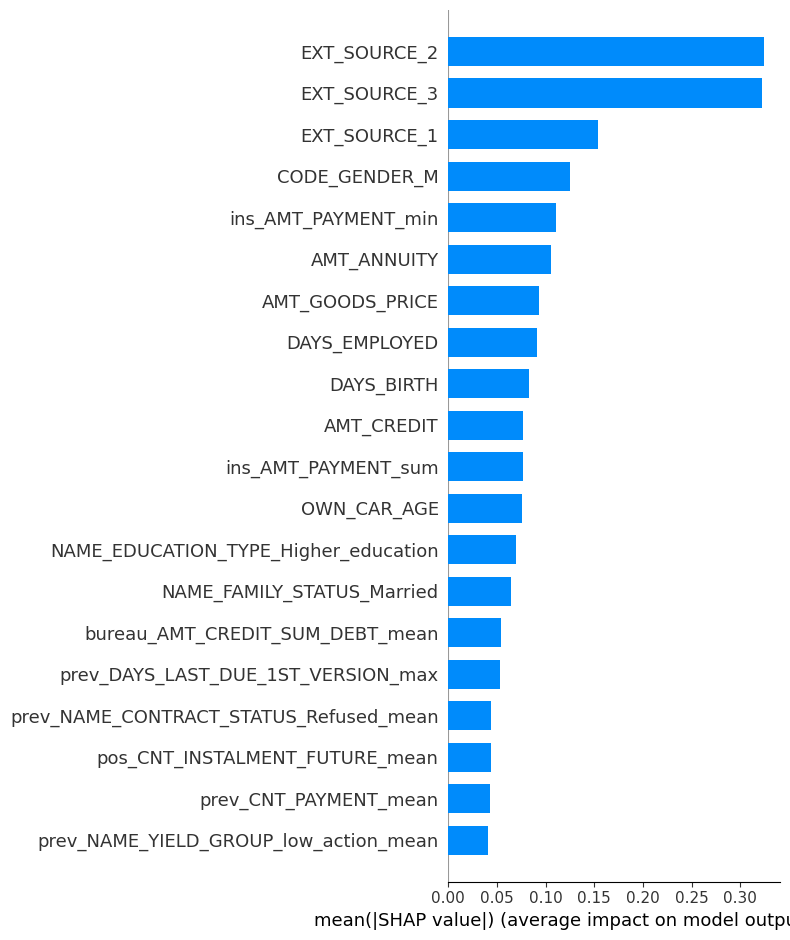

In [22]:
import shap 
import matplotlib.pyplot as plt

# 1. Initialisation de l'explainer spécifique aux arbres
explainer = shap.TreeExplainer(best_model)

# 2. Calcul des SHAP values sur le set de test
shap_values = explainer.shap_values(X_test.iloc[:1000,])

# 3. Graphique de synthèse (Summary Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar") # Importance globale

#### ANALYSE LOCALE

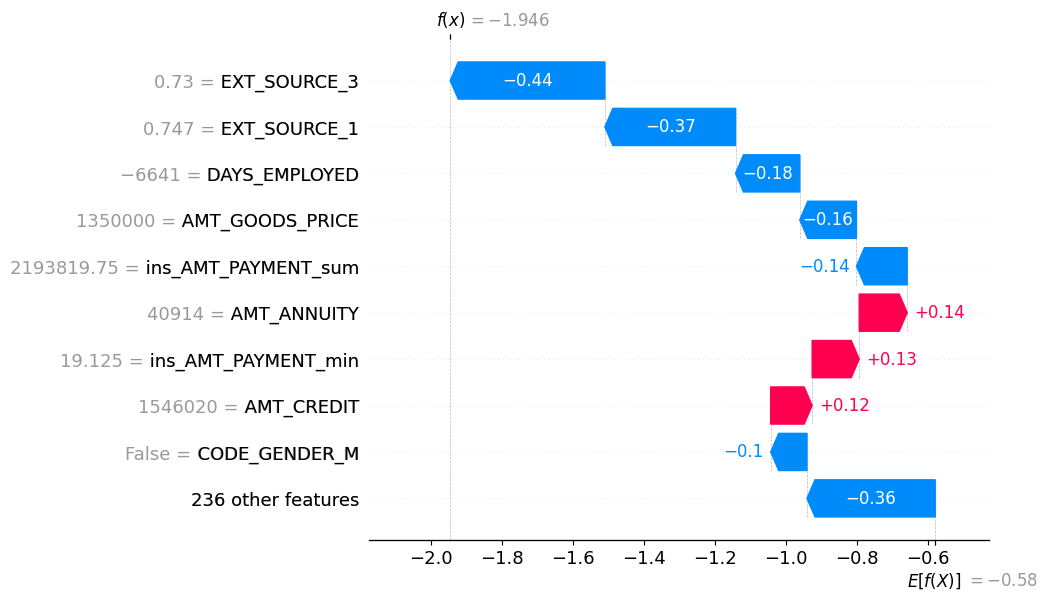

In [23]:
# On choisit un client (ex: le 10ème du set de test)
client_idx = 10
client_data = X_test.iloc[client_idx : client_idx + 1]

# Calcul SHAP pour ce client
# Pour LightGBM, shap_values est souvent une liste [prob_0, prob_1]
# On prend l'index 1 pour la probabilité de défaut
explanation = explainer(client_data)

# Waterfall Plot : Très visuel pour les refus de prêt
# Il montre comment chaque variable déplace le score de la moyenne vers la décision finale
plt.figure(figsize=(12, 4))
shap.plots.waterfall(explanation[0])